In [14]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
import precision_recall_cutoff

# Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-445-wagner'
bucket = s3.Bucket(bucket_name)

# Defining the file to be read from s3 bucket
file_key = "turnover.csv"

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# Reading the csv file
turnover = pd.read_csv(file_content_stream)
turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [15]:
#Changing to dummy variables
turnover = pd.concat([turnover.drop(columns = ['sales']), pd.get_dummies(turnover['sales'])], axis = 1)
turnover = pd.concat([turnover, pd.get_dummies(turnover['salary'])], axis = 1)

turnover.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,IT,...,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,medium,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,low,0,...,0,0,0,0,1,0,0,0,1,0


In [16]:
#Defining Varibales
X = turnover.drop(columns = ['left', 'salary'])
Y = turnover['left']

#Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

[Text(558.0, 856.1700000000001, 'satisfaction_level <= 0.465\ngini = 0.363\nsamples = 11999\nvalue = [9142, 2857]'),
 Text(279.0, 611.55, 'number_project <= 2.5\ngini = 0.478\nsamples = 3333\nvalue = [1314, 2019]'),
 Text(139.5, 366.93000000000006, 'last_evaluation <= 0.575\ngini = 0.222\nsamples = 1381\nvalue = [176, 1205]'),
 Text(69.75, 122.30999999999995, 'gini = 0.107\nsamples = 1271\nvalue = [72, 1199]'),
 Text(209.25, 122.30999999999995, 'gini = 0.103\nsamples = 110\nvalue = [104, 6]'),
 Text(418.5, 366.93000000000006, 'satisfaction_level <= 0.115\ngini = 0.486\nsamples = 1952\nvalue = [1138, 814]'),
 Text(348.75, 122.30999999999995, 'gini = 0.0\nsamples = 716\nvalue = [0, 716]'),
 Text(488.25, 122.30999999999995, 'gini = 0.146\nsamples = 1236\nvalue = [1138, 98]'),
 Text(837.0, 611.55, 'time_spend_company <= 4.5\ngini = 0.175\nsamples = 8666\nvalue = [7828, 838]'),
 Text(697.5, 366.93000000000006, 'average_montly_hours <= 290.5\ngini = 0.03\nsamples = 7075\nvalue = [6967, 108]'

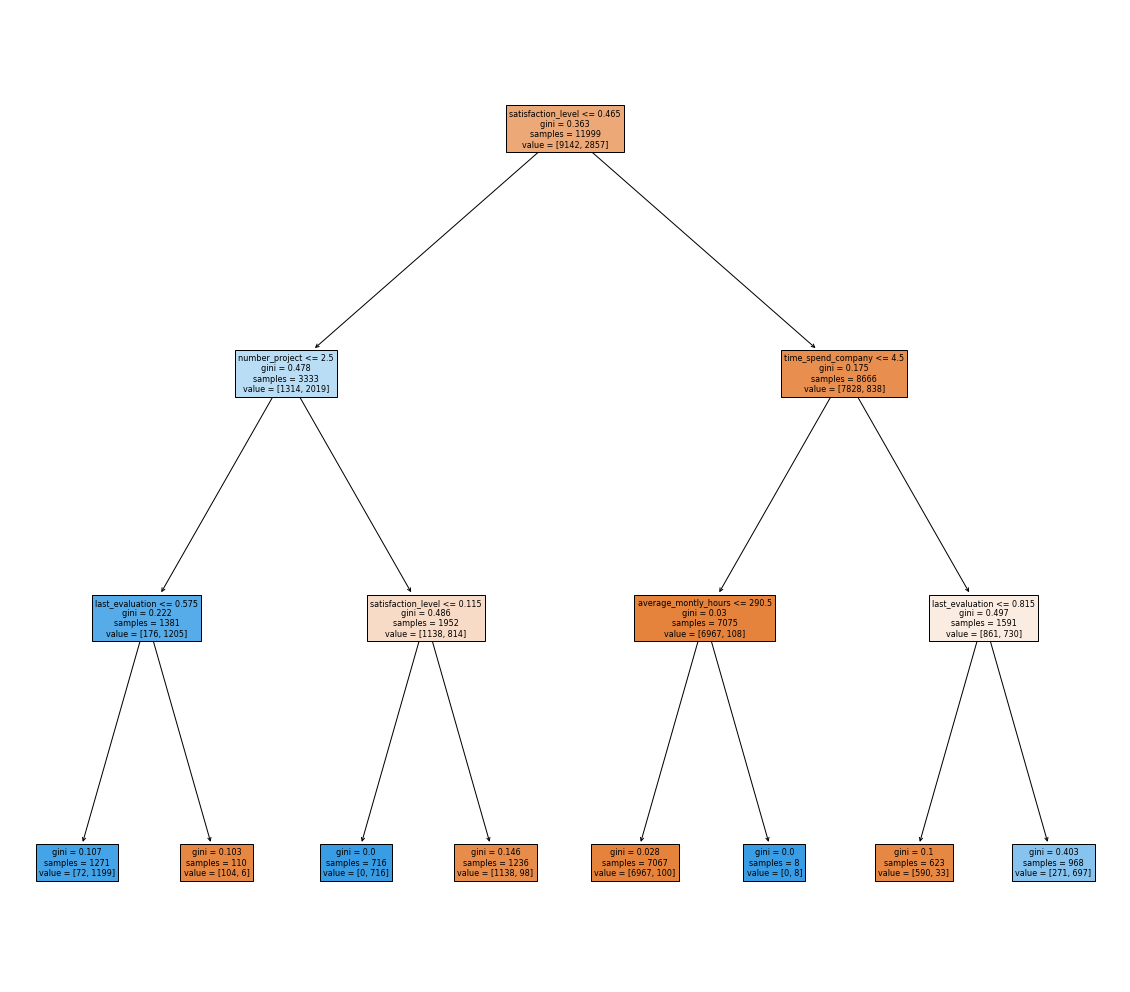

In [17]:
# Building decision tree 
md1 = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

#Visualizing model
fig = plt.figure(figsize = (20, 18))
plot_tree(md1, feature_names = X_train.columns, filled = True)

In [18]:
#Creating features
turnover['Interaction_1'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] <= 2.5) & (turnover['last_evaluation'] <= 0.575), 1, 0)
turnover['Interaction_2'] = np.where((turnover['satisfaction_level'] <= 0.465) & (turnover['number_project'] >= 2.5) & (turnover['satisfaction_level'] <= 0.115), 1, 0)
turnover['Interaction_3'] = np.where((turnover['satisfaction_level'] >= 0.465) & (turnover['time_spend_company'] <= 4.5) & (turnover['average_montly_hours'] <= 290.5), 1, 0)

In [19]:
## Defining the input and target variables
X = turnover.drop(columns = ['left', 'salary'])
Y = turnover['left']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [20]:
#Building random forest model  
RF = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

#Predicting test
RF_pred = RF.predict_proba(X_test)[:, 1]

#Predicting labels
RF_labels =prc.precision_recall_cutoff(Y_test, RF_pred)

#Computing classification report
print(classification_report(Y_test, RF_labels))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2286
           1       0.88      0.90      0.89       714

    accuracy                           0.95      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.95      0.95      0.95      3000



In [21]:
#Dropping interactions and creating model
X_train = X_train.drop(columns = ['Interaction_1', 'Interaction_2', 'Interaction_3'])
X_test = X_test.drop(columns = ['Interaction_1', 'Interaction_2', 'Interaction_3'])

#Building model
RF = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

#Predicting test
RF_pred = RF.predict_proba(X_test)[:, 1]

#Predicting labels
RF_labels =prc.precision_recall_cutoff(Y_test, RF_pred)

#Computing classification report
print(classification_report(Y_test, RF_labels))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2286
           1       0.74      0.83      0.78       714

    accuracy                           0.89      3000
   macro avg       0.84      0.87      0.85      3000
weighted avg       0.90      0.89      0.89      3000



In [ ]:
#I would use the model with the interactions as it has a much higher overall score